# IMPORTS

In [86]:
#check tensorflow versions
!pip freeze | grep tensorflow

tensorflow==2.12.0
tensorflow-datasets==4.9.2
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.20.1


In [58]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [120]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, balanced_accuracy_score


# PREPROCESSING

In [60]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [61]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 125/125 [00:06<00:00, 17.99it/s]


In [62]:
X_train.shape

(982, 224, 224, 3)

In [63]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)


# MODEL

## Define model

wow, very complicated transfer learning...

In [88]:
def load_model():

    # $CHALLENGIFY_BEGIN

    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    # model = VGG16(weights="imagenet", include_top=False, input_shape=(244, 244, 3))

    # $CHALLENGIFY_END

    return model

In [89]:
model = load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

set model as not trainable, cuz it's massive

In [90]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [91]:
model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Actually build the model

Thx for all your patience

In [127]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(50, activation='relu')
    prediction_layer = layers.Dense(14, activation='softmax')
#chanted dense from 500 to 50

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [128]:
model = add_last_layers(model)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 14)                27266202  
                                                                 
 flatten_10 (Flatten)        (None, 14)                0         
                                                                 
 dense_20 (Dense)            (None, 50)                750       
                                                                 
 dense_21 (Dense)            (None, 14)                714       
                                                                 
Total params: 27,267,666
Trainable params: 1,464
Non-trainable params: 27,266,202
_________________________________________________________________


## Compile VGG16 + layers

In [129]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


In [130]:
model = build_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 50)                1254450   
                                                                 
 dense_23 (Dense)            (None, 14)                714       
                                                                 
Total params: 15,969,852
Trainable params: 1,255,164
Non-trainable params: 14,714,688
_________________________________________________________________


## Fit the model

In [131]:
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[es])

Epoch 1/50
62/62 [==============================] - 9s 99ms/step - loss: 5.5403 - accuracy: 0.1426 - val_loss: 2.6721 - val_accuracy: 0.1456
Epoch 2/50
62/62 [==============================] - 5s 87ms/step - loss: 2.0278 - accuracy: 0.3147 - val_loss: 2.8913 - val_accuracy: 0.2201
Epoch 3/50
62/62 [==============================] - 6s 89ms/step - loss: 1.5946 - accuracy: 0.4470 - val_loss: 2.7634 - val_accuracy: 0.2718
Epoch 4/50
62/62 [==============================] - 5s 86ms/step - loss: 1.2379 - accuracy: 0.5540 - val_loss: 3.0581 - val_accuracy: 0.2945
Epoch 5/50
62/62 [==============================] - 5s 89ms/step - loss: 1.0137 - accuracy: 0.6263 - val_loss: 3.1759 - val_accuracy: 0.3010
Epoch 6/50
62/62 [==============================] - 5s 86ms/step - loss: 0.7824 - accuracy: 0.7118 - val_loss: 3.3796 - val_accuracy: 0.3172
Epoch 7/50
62/62 [==============================] - 5s 86ms/step - loss: 0.6038 - accuracy: 0.7800 - val_loss: 3.5521 - val_accuracy: 0.3333
Epoch 8/50
62

### Plot accuracy

In [133]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

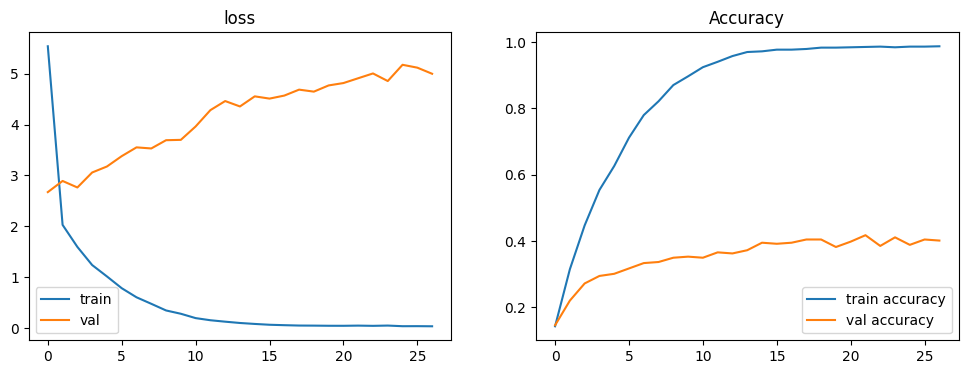

In [134]:
plot_history(history)

## Evaluate the model

In [135]:
res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')



9/9 [==============================] - 1s 121ms/step - loss: 4.3973 - accuracy: 0.4302
test_accuracy_vgg = 43.0 %
Chance level: 7.1%


### Create predictions

In [136]:
predictions = model.predict(X_test)


9/9 [==============================] - 1s 127ms/step


In [137]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [138]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Create scoring metric

#### Create f1 scoring metrics

In [139]:
# Return macro f1
f1 = f1_score(y_test_argmax, y_pred, average='macro')

# Return weighted f1
f1_score_weighted = f1_score(y_test_argmax, y_pred, average='weighted')
f1, f1_score_weighted

(0.4124536623961855, 0.42763932034598245)

#### Create precision metric

In [140]:
# Return macro precision
precision = precision_score(y_test_argmax, y_pred, average='macro')

# Return weighted precision
precision_score_weighted = precision_score(y_test_argmax, y_pred, average='weighted')
precision, precision_score_weighted

(0.4212934934739446, 0.4477157922996357)

#### Create recall metric

In [141]:
# Return macro precision
recall = recall_score(y_test_argmax,y_pred, average='macro')

# Return weighted precision
recall_weighted = recall_score(y_test_argmax,y_pred, average='weighted')
recall, recall_weighted

(0.4299865137442537, 0.43023255813953487)

#### Create accuracy metric

In [142]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.43023255813953487, 0.4299865137442537)

### Confusion Matrix for class analysis

In [144]:
cm = confusion_matrix(y_test_argmax, y_pred)

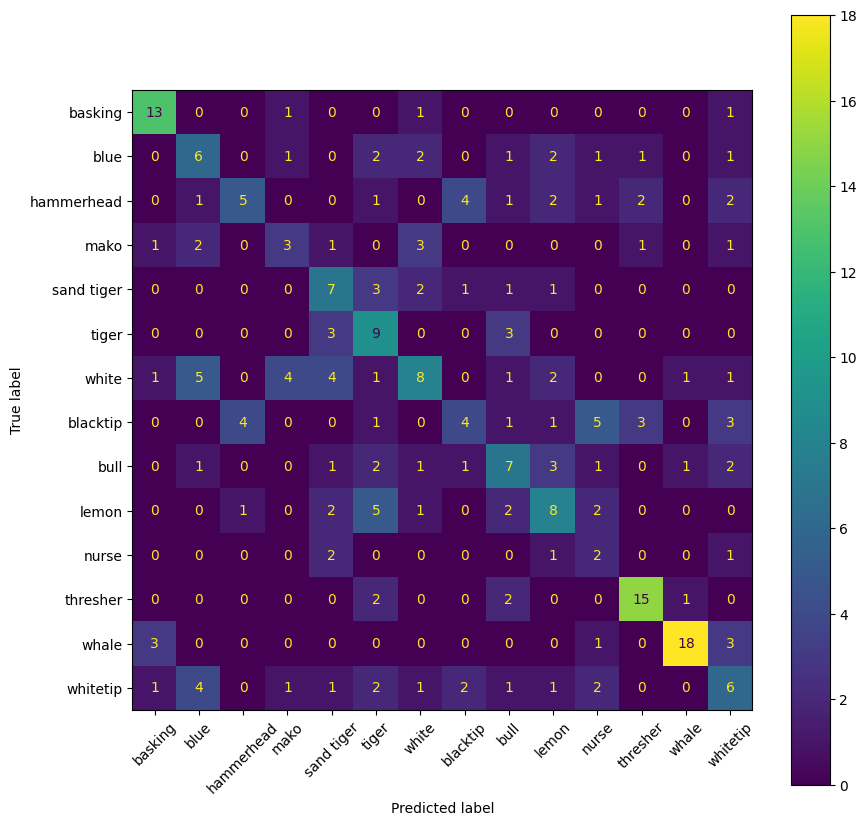

In [145]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()